# Importation des modules

In [1]:
%pip install sounddevice --upgrade

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import scipy.io.wavfile as wav


# Création du message et transformation ASCII -> Binaire

In [3]:
def textToBinary(text: str):
    """
    Fonction permettant de transformer une chaine de caractère en liste binaire.

    Parameters
    ----------
    text : str
        Chaine de caractère (entre 5 et 10 pour notre exemple).

    Returns
    -------
    returnList : list
        Une liste de bits, correspondant au code ASCII de chaque caractère.

    """
    returnList, baseList = list(), list()
    for e in text:
        baseList.append(bin(ord(e)))
    for e in baseList:
        if len(e) != 10:
            for i in range(10-len(e)):
                returnList.append(0)
        for i in range(2, len(e)):
            returnList.append(int(e[i]))
    return (returnList)

In [4]:
# Pour notre prototype, nous n'utiliserons qu'un mesage d'entre 5 et 10 caractères ("Bonjour !" ← l'espace est important)
textToSend = input("Entrez le message à envoyer : ")
print(f"\nLe message que vous voulez envoyer est : '{textToSend}'")
input("")
textToSend = textToBinary(textToSend)
print(f"Le message sous forme binaire est :\n{textToSend}")

Entrez le message à envoyer : Test

Le message que vous voulez envoyer est : 'Test'

Le message sous forme binaire est :
[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0]



# Création d'un code CRC

In [5]:
def crc_encode(data: list, key=[1, 0, 0, 1, 0]):
    """
    Fonction permettant de générer un code CRC a partir d'une liste de bits.

    Parameters
    ----------
    data : list
        Une liste de bits correspondant au message auquel générer un code CRC.
    key : TYPE, optional
        clée polynomiale. The default is [1, 0, 0, 1, 0].

    Returns
    -------
    list
        Le code CRC sous forme de liste de bits.

    """
    data_extended = data + [0] * (len(key) - 1)
    remainder = list(data_extended)
    for i in range(len(data_extended) - len(key) + 1):
        if remainder[i] == 1:
            for j in range(len(key)):
                remainder[i + j] ^= key[j]
    return remainder[-(len(key) - 1):]

In [6]:
crc = crc_encode(textToSend)
print(f"Le code CRC est : {crc}")

Le code CRC est : [1, 1, 0, 0]



# Création d'une trame de donnés

In [7]:
def toFrame(data: list, crc: list):
    """
    Fonction permettant de créer une trame de bits en fonction d'une liste de
    bits représentant les donnés à envoyer et du code CRC des mêmes donnés.

    Parameters
    ----------
    data : list
        Une liste de bits correspondant au message auquel générer un code CRC.
    crc : list
        Code CRC des donnés binaryList.

    Returns
    -------
    returnList : list
        Une liste de bits composé de deux fanions au extrêmités, de la donnée
        principale et d'un code CRC.

    """
    flag = [0, 1, 1, 1, 1, 1, 1, 0]  # Le flag choisis est 7E (HDLC)
    returnList = flag + data + crc + flag
    return returnList

In [8]:
textToSend = toFrame(textToSend, crc)
print(f"La trame de donnés à encoder est : \n{textToSend}")

La trame de donnés à encoder est : 
[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]



# Encodage manchester

In [9]:
def manchester_encode(data: list):
    """
    Fonction permettant d'encoder des données binaire grâce au codage manchester.
    Cela consiste à transformer du binaire grâce à une horloge. Un zéro deviens donc
    une descente (de 0 à 1) et un un deviens une montée (de 1 à 0)

    Parameters
    ----------
    data : list
        Une liste de bits.

    Returns
    -------
    dataManchester : TYPE
        Une liste de bits encodée via manchester.

    """
    dataManchester = []
    for i in range(0, len(data)):
        if data[i] == 0:
            dataManchester.append(1)
            dataManchester.append(0)
        else:
            dataManchester.append(0)
            dataManchester.append(1)
    return dataManchester

In [10]:
textToSend = manchester_encode(textToSend)
print(f"Les données à moduler sonts : \n{textToSend}")

Les données à moduler sonts : 
[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]



# Modulataion ASK

In [11]:
def modulation_ASK(data: list, sampling_frequency=44100):
    """
    Une fonction permettant de transformer un signal binaire en onde grâce à une porteuse.
    La fréquence est choisis par défaut, mais elle peut être choisie.

    Parameters
    ----------
    data : list
        Donnés binaire à moduler.
    sampling_frequency : int
        Fréquence d'échantillonnage (en sec^-1)
    
    Returns
    -------
    Fe : int
        Fréquence d'échantillonnage (en sec^-1)
    ASK : list
        Liste de donnés modulés.

    """
    baud = 300   # Débit souhaité sur le canal de transmission exprimé en bit/s
    Ns = int(sampling_frequency / baud)   # Nombre de symboles par bit (Fréq d'echantillonage / Débit)
    N = int(Ns * len(data))   # Nombre de bits à moduler
    data_ = np.repeat(data, Ns)
    t = np.linspace(0, N / sampling_frequency, N)
    porteuse = 1 * np.sin(2 * np.pi * 25000 * t)
    ASK =  data_ * porteuse
    
    plt.figure(figsize=(12, 6))
    plt.plot(t, data_, "red")
    plt.xlabel("temps")
    plt.title("Binaire")
    plt.savefig("binaire.png")
    
    # Figure illisible (fréquence trop élevée).
    '''plt.figure(figsize=(12, 6))
    plt.plot(t, porteuse, "red")
    plt.xlabel("temps")
    plt.title("Porteuse")
    plt.savefig("porteuse.png")'''
    
    plt.figure(figsize=(12, 6))
    plt.plot(t, ASK, "red")
    plt.xlabel("temps")
    plt.title("ASK")
    plt.savefig("ask.png")
    
    return ASK, sampling_frequency

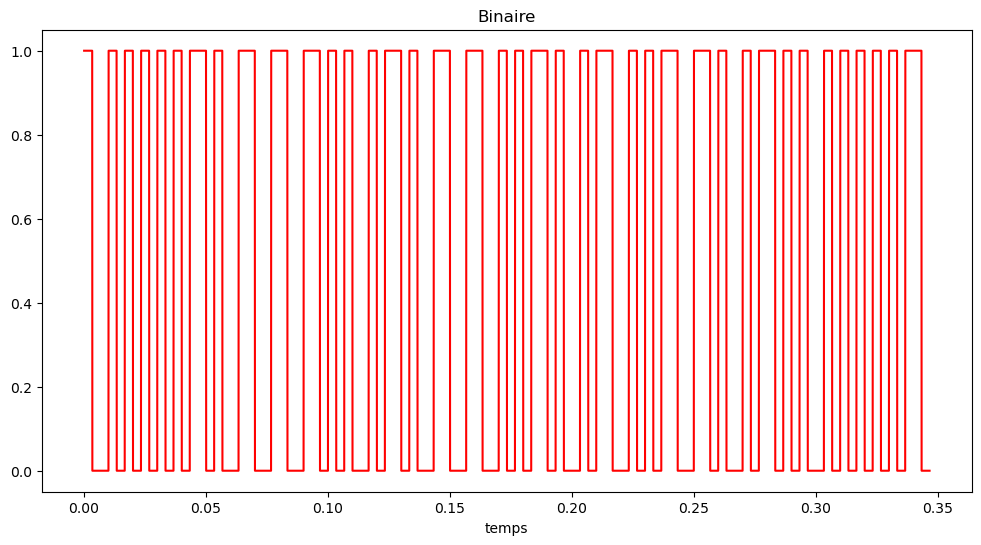

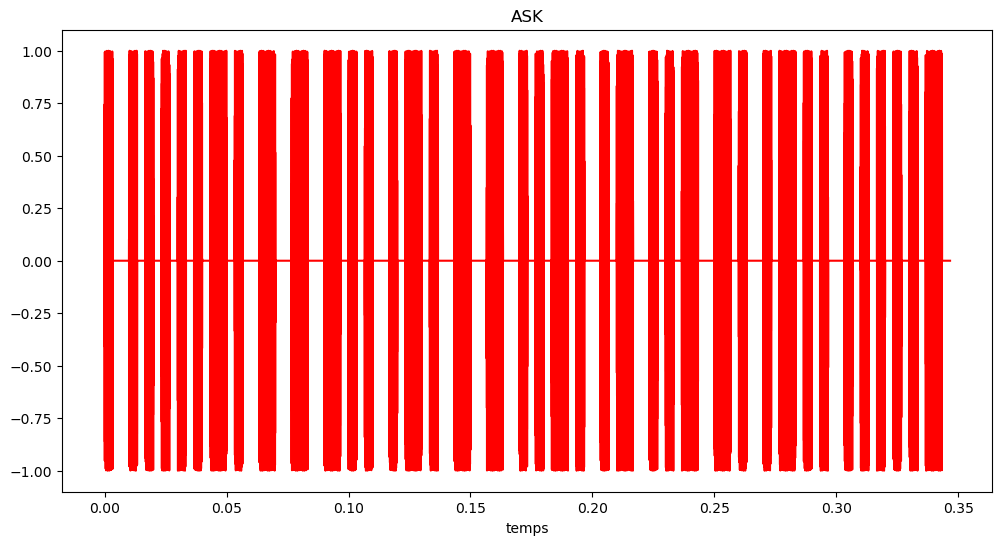

In [12]:
(ASK, sampling_frequency) = modulation_ASK(textToSend)


# Envoi du message

In [13]:
wav.write("soundExport.wav", sampling_frequency, ASK)
print("Le message a bien été envoyé !")

Le message a bien été envoyé !





# Réception du message

In [14]:
f, file = wav.read('soundExport.wav')
print("Le message a bien été reçu !")

Le message a bien été reçu !



# Démodulation du message

In [15]:
def demodulation_ASK(ASK: list):
    """
    Fonction permettant de démoduler des donnés ASK.
    Note : L'erreur peut être ignorée, lors de la division des donnés par la porteuse,
    il arrive qu'il y ait des divisions par zéro, mais python peut passer outre.

    Parameters
    ----------
    ASK : list
        Liste de donnés ASK à démoduler.

    Returns
    -------
    data_ : list
        Liste binaire correspondant au donnés démodulés.

    """
    sampling_frequency = 44100
    baud = 300
    Ns = int(sampling_frequency / baud)
    N = len(ASK)
    t = np.linspace(0, N / sampling_frequency, N)
    porteuse = 1 * np.sin(2 * np.pi * 25000 * t)
    data = [0 for i in range(len(ASK))]
    for i in range(len(ASK)):
        try:
            data[i] = int(ASK[i]/porteuse[i])
        except:
            data[i] = -1
    data_ = [data[i] for i in range(1, len(data), Ns)]
    return data_

In [16]:
data = demodulation_ASK(file)
print(data)

[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0]


C:\Users\n4t10\AppData\Local\Temp\ipykernel_257512\1855716430.py:27: RuntimeWarning: invalid value encountered in scalar divide
  data[i] = int(ASK[i]/porteuse[i])


# Décodage manchester

In [17]:
def manchester_decode(data: list):
    """
    Fonction transformant une liste encodé en une liste décodé via manchester (utilisation d'une horloge).

    Parameters
    ----------
    data : list
        Liste de bits à décoder.

    Returns
    -------
    data_ : list
        Liste de bits décodés.

    """
    data_ = []
    for i in range(0, len(data), 2):
        if data[i] == 0:
            data_.append(1)
        else:
            data_.append(0)
    return data_

In [18]:
data = manchester_decode(data)
print(data)

[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0]


# Identification de la trame

In [19]:
def pattern(data: list, pattern: list):
    """
    Fonction permettant de trouver un motif sous forme de liste, dans une plus grande liste.

    Parameters
    ----------
    data : list
        Liste de bits où trouver le motif.
    pattern : list
        Liste de bits correspondant au motif à trouver.

    Returns
    -------
    i : int
        Indice de la liste data où est positioné le premier motif.

    """
    pLen = len(pattern)
    for i in range(len(data) - pLen + 1):
        if data[i:i + pLen] == pattern:
            return i
    return -1


def searchFlags(data: list):
    """
    Fonction permettant de trouver des fanions 0x7E (0b01111110) puis de renvoyer
    les donnés entre ses deux fanions sous forme de liste de bits.

    Parameters
    ----------
    data : list
        Liste de bits.

    Returns
    -------
    data_ : list
        Listde de bits correspondant au donnés entre les fanion.

    """
    temp, data_ = list(), list()
    p = pattern(data, [0, 1, 1, 1, 1, 1, 1, 0])
    if p != -1:
        temp = data[p+8:]
        p = pattern(temp, [0, 1, 1, 1, 1, 1, 1, 0])
        if p != -1:
            data_ = temp[:p]
            return data_
    return [-1, data]

In [20]:
data = searchFlags(data)
print(data)

[0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]


# Vérification CRC

In [21]:
def testCRC(data: list, key_: list, key=[1, 0, 0, 1, 0]):
    """
    Fonction permettant de générer un code CRC a partir d'une liste de bit et d'un
    polynome (de base généré). 

    Parameters
    ----------
    data : list
        Une liste de bits correspondant au message auquel générer un code CRC.
    key_ : list
        La clef CRC reçue.
    key : TYPE, optional
        Clef polynomiale. (The default is [1, 0, 0, 1, 0]).

    Returns
    -------
    bool
        True = Il n'y a pas eu de pertes de donnés.
        False = Il y a pertes de donnés.

    """
    remainder = []
    data_extended = data + [0] * (len(key) - 1)
    remainder = list(data_extended)
    for i in range(len(data_extended) - len(key) + 1):
        if remainder[i] == 1:
            for j in range(len(key)):
                remainder[i + j] ^= key[j]
    remainder = remainder[-(len(key) - 1):]
    print(f"Le code reçue est est {key_}")
    print(f"Le code trouvé est {remainder}")
    if remainder == key_:
        print("Pas de perte")
        return True
    else:
        print("Il y a eu une perte de donnés")
        return False

In [22]:
data, crc = data[:len(data)-4], data[len(data)-4:]
check = testCRC(data, crc)

Le code reçue est est [1, 1, 0, 0]
Le code trouvé est [1, 1, 0, 0]
Pas de perte


# Traduction du message (Binaire -> ASCII)

In [23]:
def binToText(data: list):
    """
    Fonction qui transforme une list de bits en leurs correspondance
    ascii texte. Il faut que les donnés soit un multiple de huit.

    Parameters
    ----------
    data : list
        Liste de bits.
    Returns
    -------
    txt : str
        Chaine de caractère correspondant a la transcription ASCII des octets.

    """
    txt, tmp, decimalList = "", 0, []
    for i in range(0, len(data), 8):
        tmpL, tmp = [], 0
        for j in range(8):
            tmpL.append(data[i+j])
        tmpL.reverse()
        for i in range(8):
            tmp += tmpL[i] * (2 ** i)
        decimalList.append(tmp)
    for e in decimalList:
        txt += chr(e)
    return txt

In [24]:
txt = binToText(data)
print(f"Le massage est :\n{txt}")

Le massage est :
Test
